In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )

def split_and_store(row):
    split_parts = row['response'].split("\n\nInstruction", 1)
    return split_parts[0]


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_t5_base = pd.read_csv("./data/flan-t5-base.csv")
df_flan_t5_large = pd.read_csv("./data/flan-t5-large.csv")
df_flan_t5_xl = pd.read_csv("./data/flan-t5-xl.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_base = df_flan_t5_base.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_large = df_flan_t5_large.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_xl = df_flan_t5_xl.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,1. The sentence is about Republican state legi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...","First, we need to define the term 'bias'. Bias...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
16,TrumpWorld also reflects the horrible surreali...,1. The sentence contains a reference to a spec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
17,The American Psychological Association has sai...,1. The sentence is about a statement made by t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",1. The sentence is about firearms and children...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4108,About one quarter of the world’s population li...,1. The sentence is about a specific type of la...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4109,"In her Instagram story, Jedrzejczyk posted an ...","1. The sentence is about a public figure, spec...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4111,"Facebook posts, shared thousands of times, cla...",1. The sentence claims that Melinda Gates has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4112,U.S. President Donald Trump’s former personal ...,"1. The sentence is about Michael Cohen, a pers...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif ("NOT BIASED".lower() not in row['response'].lower() and "BIASED".lower() not in row['response'].lower()) and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
56,The legislation ends criminal penalties for se...,1. The sentence is about a law that defines a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
85,President Donald Trump proposed eliminating fe...,"First, we need to identify the subject of the ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
108,A trio of polls released ahead of Wednesday’s ...,1. The sentence contains a reference to a majo...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
129,"In the seven years since, Warren has become th...",1. Identify the subject: 'Warren'.\n2. Identif...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
298,"According to The Guardian, many people are fea...","1. The sentence is from The Guardian, a newspa...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3920,Union leaders met with senior congressional De...,1. The sentence mentions a specific proposal f...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3960,Warren last year introduced a proposal that wo...,1. Identify the subject of the sentence: Warre...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3971,While Pace receives her spiritual grace from a...,"First, we should consider the religious affili...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4008,"They back more gun control laws, deflecting bl...","First, we need to identify the subject of the ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
df_falcon_7b.loc[[4008, 3883, 3829, 3768, 3725, 3647, 
                  3611, 3219, 2904, 2520, 2034, 2009,
                  695, 584, 473, ], 'label'] = 'BIASED'
df_falcon_7b.loc[[3960, 3739, 3670, 3559, 3508, 3351,
                  2876, 2492, 2098, 1796, 1786, 1463,
                  1325, 1250, 1063, 1046, 1040, 890,
                  829, 622, 351, 298, 108, 56], 'label'] = 'NOT BIASED'

df_falcon_7b.loc[[4053, 3971, 3920, 3493, 3319, 3147,
                  2730, 2704, 2561, 2341, 2240, 2121,
                  2102, 1851, 1846, 1781, 1550, 1459,
                  1441, 1178, 804, 380, 328, 129, 85,
                  ], 'label'] = '!'


df_falcon_7b.query("label == '?'")

# Assessment (example)
# 1. Identify the subject of the sentence,
# 2a. Consider the source of the sentence
# 3. Analyze the sentence to see if it is presenting a balanced view of the situation. (or factual/ objective)
# 4. Look at the sentence's language and tone.
# 5. Consider the sentence's implications and whether it is likely to influence the reader's opinion.
# 6. Finally, determine whether the sentence is likely to be BIASED or NOT BIASED.


,text,response,raw_data,query,label


In [6]:
# map "!" flag back to "?"
df_falcon_7b['label'] = df_falcon_7b['label'].replace('!', '?')

df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (0 shot CoT): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (0 shot CoT): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (0 shot CoT): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (0 shot CoT): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (0 shot CoT):  0.6542882404951371
Precision with Falcon 7b with (0 shot CoT):  0.5010155721056195
Recall with Falcon 7b with (0 shot CoT):  0.9426751592356688
Accuracy with Falcon 7b with (0 shot CoT):  0.519950890116636


# Flan T5 Base

In [8]:
df_flan_t5_base.query("label == '?'")

,text,response,raw_data,query,label


In [9]:
df_flan_t5_base = df_flan_t5_base.rename(columns={"label": "flan_t5_base_label"})
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('BIASED', 1)
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_base[['text', 'flan_t5_base_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_base_label = df_merge['flan_t5_base_label'].astype(int)

In [10]:
print("F1-Score with Flan T5 base (0 shot CoT): ", f1_score(ground_truth, flan_t5_base_label))
print("Precision with Flan T5 base (0 shot CoT): ", precision_score(ground_truth, flan_t5_base_label))
print("Recall with Flan T5 base (0 shot CoT): ", recall_score(ground_truth, flan_t5_base_label))
print("Accuracy with Flan T5 base (0 shot CoT): ",  accuracy_score(ground_truth, flan_t5_base_label))

F1-Score with Flan T5 base (0 shot CoT):  0.6601239669421488
Precision with Flan T5 base (0 shot CoT):  0.5022268797484936
Recall with Flan T5 base (0 shot CoT):  0.9628327473631341
Accuracy with Flan T5 base (0 shot CoT):  0.5090773439442925


# Flan T5 Large

In [11]:
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED is the opposite of not biased.,BIASED is the opposite of not biased.,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,Not biased is the opposite of biased. So the a...,Not biased is the opposite of biased. So the a...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...","BIASED is the opposite of not biased. So, the ...","BIASED is the opposite of not biased. So, the ...",You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,BIASED is the opposite of not biased. The sent...,BIASED is the opposite of not biased. The sent...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED is the opposite of not biased. The Repu...,BIASED is the opposite of not biased. The Repu...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,BIASED is the opposite of not biased. George F...,BIASED is the opposite of not biased. George F...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED is the opposite of not biased. George F...,BIASED is the opposite of not biased. George F...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED is the opposite of what the author is t...,BIASED is the opposite of what the author is t...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED is the opposite of not biased. The pass...,BIASED is the opposite of not biased. The pass...,You are an expert in media bias.\n\nInstructio...,?


In [12]:
def update_label(row):
    if str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).endswith('answer is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).endswith('answer is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).endswith('The answer: BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).endswith('The answer: NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    
    elif ("BIASED".lower() not in str(row['response']).lower() and "NOT BIASED".lower() not in str(row['response']).lower()) and row[
        'label'] == '?':
        return '!'
    elif "BIASED is the opposite of not biased.".lower() == str(row['response']).lower() and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_flan_t5_large['label'] = df_flan_t5_large.apply(update_label, axis=1)
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label
110,The white nationalist who said “Hail Trump” an...,BIASED is the opposite of not biased. The whit...,BIASED is the opposite of not biased. The whit...,You are an expert in media bias.\n\nInstructio...,?
166,A group of 20 wealthy individuals – including ...,BIASED is the opposite of not biased. Soros is...,BIASED is the opposite of not biased. Soros is...,You are an expert in media bias.\n\nInstructio...,?
296,"The financial backers of the BLM movement, suc...",BIASED is the opposite of not biased. Soros an...,BIASED is the opposite of not biased. Soros an...,You are an expert in media bias.\n\nInstructio...,?
1009,"That response, Americans would learn days late...",BIASED is the opposite of not biased. Soleiman...,BIASED is the opposite of not biased. Soleiman...,You are an expert in media bias.\n\nInstructio...,?
1341,Athletes and fans are excited for Sowers' hist...,BIASED is the opposite of not biased. Sowers' ...,BIASED is the opposite of not biased. Sowers' ...,You are an expert in media bias.\n\nInstructio...,?
1357,"The Labour politician, who has presided over a...",BIASED is the opposite of not biased. The Labo...,BIASED is the opposite of not biased. The Labo...,You are an expert in media bias.\n\nInstructio...,?
1400,The long-simmering U.S.-Iran conflict hit a ne...,Not biased is the opposite of biased. Soleiman...,Not biased is the opposite of biased. Soleiman...,You are an expert in media bias.\n\nInstructio...,?
1851,It is far from the first time that Trump has o...,NOT BIASED is the opposite of biased.,NOT BIASED is the opposite of biased.,You are an expert in media bias.\n\nInstructio...,?
1893,George Soros does not “own” ANTIFA or Black Li...,BIASED is the opposite of not biased. Soros do...,BIASED is the opposite of not biased. Soros do...,You are an expert in media bias.\n\nInstructio...,?
2378,Fears of an all-out war between the United Sta...,BIASED is the opposite of not biased. Soleiman...,BIASED is the opposite of not biased. Soleiman...,You are an expert in media bias.\n\nInstructio...,?


In [13]:
df_flan_t5_large.response.loc[4009]

'Not biased is the opposite of biased. Soleimani was killed in an airstrike. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in a plane crash. Soleimani was killed in '

In [14]:
#manual assignment
df_flan_t5_large.loc[[], 'label'] = 'BIASED'
df_flan_t5_large.loc[[3116], 'label'] = 'NOT BIASED'

df_flan_t5_large.loc[[110, 166, 296, 1009, 1341, 
                      1357, 1400, 1851, 2378, 1893,  
                      2402, 3241, 3300, 3312, 3339,
                      4009,], 'label'] = '!'


df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label


In [15]:
#map '!' flag back to "?"
df_flan_t5_large['label'] = df_flan_t5_large['label'].replace('!', '?')

df_flan_t5_large = df_flan_t5_large.rename(columns={"label": "flan_t5_large_label"})
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('BIASED', 1)
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_large[['text', 'flan_t5_large_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_large_label = df_merge['flan_t5_large_label'].astype(int)

In [16]:
print("F1-Score with Flan T5 Large (0 shot CoT): ", f1_score(ground_truth, flan_t5_large_label))
print("Precision with Flan T5 Large (0 shot CoT): ", precision_score(ground_truth, flan_t5_large_label))
print("Recall with Flan T5 Large (0 shot CoT): ", recall_score(ground_truth, flan_t5_large_label))
print("Accuracy with Flan T5 Large (0 shot CoT): ",  accuracy_score(ground_truth, flan_t5_large_label))

F1-Score with Flan T5 Large (0 shot CoT):  0.5869001297016861
Precision with Flan T5 Large (0 shot CoT):  0.71939586645469
Recall with Flan T5 Large (0 shot CoT):  0.49561883899233294
Accuracy with Flan T5 Large (0 shot CoT):  0.6382737081203862


# Flan T5 XL

In [17]:
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,BIASED. The sentence is a statement of fact. T...,BIASED. The sentence is a statement of fact. T...,You are an expert in media bias.\n\nInstructio...,?
160,"Memories of smashed windows, stolen merchandis...",Not biased. The article is not biased and does...,Not biased. The article is not biased and does...,You are an expert in media bias.\n\nInstructio...,?
203,Cable news is poison.,BIASED. The sentence is not biased because it ...,BIASED. The sentence is not biased because it ...,You are an expert in media bias.\n\nInstructio...,?
237,The Heroes Act contains many leftist provision...,BIASED. The sentence is not biased because it ...,BIASED. The sentence is not biased because it ...,You are an expert in media bias.\n\nInstructio...,?
239,"On Saturday, there were numerous assaults by l...",Not biased. The sentence is not biased. The fa...,Not biased. The sentence is not biased. The fa...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3894,Dozens of bills to change the flag are filed i...,Not biased. The reporter did not state that th...,Not biased. The reporter did not state that th...,You are an expert in media bias.\n\nInstructio...,?
3898,A fifth of U.S. trans people reported discrimi...,Not biased because the National Center for Tra...,Not biased because the National Center for Tra...,You are an expert in media bias.\n\nInstructio...,?
4013,"Trump, of course, is his most stunning when he...",Not biased. The sentence is not biased. It is ...,Not biased. The sentence is not biased. It is ...,You are an expert in media bias.\n\nInstructio...,?
4039,"April, typically a big revenue month for U.S. ...",Not biased. The article is not biased. It is u...,Not biased. The article is not biased. It is u...,You are an expert in media bias.\n\nInstructio...,?


In [18]:
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).endswith('answer is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).endswith('answer is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_flan_t5_xl['label'] = df_flan_t5_xl.apply(update_label, axis=1)
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label


In [19]:
df_flan_t5_xl = df_flan_t5_xl.rename(columns={"label": "flan_t5_xl_label"})
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('BIASED', 1)
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_xl[['text', 'flan_t5_xl_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_xl_label = df_merge['flan_t5_xl_label'].astype(int)

In [20]:
print("F1-Score with Flan T5 xl (0 Shot CoT): ", f1_score(ground_truth, flan_t5_xl_label))
print("Precision with Flan T5 xl (0 Shot CoT): ", precision_score(ground_truth, flan_t5_xl_label))
print("Recall with Flan T5 xl (0 Shot CoT): ", recall_score(ground_truth, flan_t5_xl_label))
print("Accuracy with Flan T5 xl (0 Shot CoT): ",  accuracy_score(ground_truth, flan_t5_xl_label))

F1-Score with Flan T5 xl (0 Shot CoT):  0.5494648070061628
Precision with Flan T5 xl (0 Shot CoT):  0.7756410256410257
Recall with Flan T5 xl (0 Shot CoT):  0.425414364640884
Accuracy with Flan T5 xl (0 Shot CoT):  0.6545635414076101


# Flan UL2

In [21]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label
257,Big Ten Commissioner Jim Delany told The Athle...,Not biased because it is just reporting what w...,Not biased because it is just reporting what w...,You are an expert in media bias.\n\nInstructio...,?
591,He looks to quickly put his stamp on the court...,BIASED The sentence is biased because it is de...,BIASED The sentence is biased because it is de...,You are an expert in media bias.\n\nInstructio...,?
926,The votes come as a new conservative majority ...,BIASED Because the sentence is talking about a...,BIASED Because the sentence is talking about a...,You are an expert in media bias.\n\nInstructio...,?
1462,Hawley said he had asked Shogan to provide her...,Not Biased because it is true and not a biased...,Not Biased because it is true and not a biased...,You are an expert in media bias.\n\nInstructio...,?
1598,During her acceptance speech for best actress ...,Not biased. Williams went on a bizarre rant ab...,Not biased. Williams went on a bizarre rant ab...,You are an expert in media bias.\n\nInstructio...,?
1745,"In response to the hacking, the United States ...","BIASED Because the sentence is true, it is not...","BIASED Because the sentence is true, it is not...",You are an expert in media bias.\n\nInstructio...,?
1960,Two police officers have been arrested for all...,Not biased because it is a true story. The Geo...,Not biased because it is a true story. The Geo...,You are an expert in media bias.\n\nInstructio...,?
2126,"Nevertheless, The Jesus Is King crooner launch...",Not biased because it is not a biased opinion....,Not biased because it is not a biased opinion....,You are an expert in media bias.\n\nInstructio...,?
2129,"In addition to the 10 people who were killed, ...",BIASED Because the sentence only mentions the ...,BIASED Because the sentence only mentions the ...,You are an expert in media bias.\n\nInstructio...,?
2137,The Sandy Hook tragedy rocked the United State...,BIASED Because the sentence is about a tragedy...,BIASED Because the sentence is about a tragedy...,You are an expert in media bias.\n\nInstructio...,?


In [22]:
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Not Biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_flan_ul2['label'] = df_flan_ul2.apply(update_label, axis=1)
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [23]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [24]:
print("F1-Score with Flan UL2 (0 shot CoT): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (0 shot CoT): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (0 shot CoT): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (0 shot CoT): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (0 shot CoT):  0.7304166666666666
Precision with Flan UL2 (0 shot CoT):  0.6240655037379851
Recall with Flan UL2 (0 shot CoT):  0.880462079357107
Accuracy with Flan UL2 (0 shot CoT):  0.6781895050982343


# GPT-3.5-turbo

In [25]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
16,TrumpWorld also reflects the horrible surreali...,The sentence provided does not exhibit any exp...,"{\n ""id"": ""chatcmpl-8UgsIoQ1Gx4VETvvlIEkWnAlh...","[{'role': 'system', 'content': 'You are an exp...",?
21,Donald Trump signed an executive order for thi...,The sentence provided does not contain any exp...,"{\n ""id"": ""chatcmpl-8UgsRKY2J6vNEJiQiPhm2qARN...","[{'role': 'system', 'content': 'You are an exp...",?
24,Disney’s executives stopped advertising on Tuc...,The sentence above contains a claim about Disn...,"{\n ""id"": ""chatcmpl-8UgsYajTInNbL6p8stV4hJe4d...","[{'role': 'system', 'content': 'You are an exp...",?
30,"n Dr. King's day, that other America was, for ...",The sentence above does not exhibit any explic...,"{\n ""id"": ""chatcmpl-8Ugspkj9lEQk3r7iSJAHrH65k...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provided appears to be a factual ...,"{\n ""id"": ""chatcmpl-8Ugt4k7eD1WQYw7FU7r6pTVJ9...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
4005,"The night before the rant, the Jesus Is King r...",The sentence provided does not appear to be bi...,"{\n ""id"": ""chatcmpl-8UioQ5zGC5aiaSJIS6WVRw0Wy...","[{'role': 'system', 'content': 'You are an exp...",?
4006,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence provided does not appear to conta...,"{\n ""id"": ""chatcmpl-8UioRNKOKTL0edU2r1nsealAI...","[{'role': 'system', 'content': 'You are an exp...",?
4007,"In June, an explosive early morning fire rocke...",The sentence provided does not exhibit any cle...,"{\n ""id"": ""chatcmpl-8UioTFR6NNtAFWbjpHHxnklgn...","[{'role': 'system', 'content': 'You are an exp...",?
4009,"In her Instagram story, Jedrzejczyk posted an ...",The sentence provided does not exhibit any obv...,"{\n ""id"": ""chatcmpl-8UioWfsHMgt4FiE2XCWFpwnzH...","[{'role': 'system', 'content': 'You are an exp...",?


In [26]:
def update_label(row):
    if row['response'].startswith(
        'The sentence provided does not exhibit any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not contain any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not display any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not exhibit any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence above does not exhibit any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not explicitly display any bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provided does not') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not contain any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as potentially biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence provided contains some elements that could potentially indicate bias') and \
        row[
            'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence "He did not elaborate" is a neutral statement that does not show any bias.') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not appear to contain any explicit bias') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']



df_openai_gpt_3_5_turbo['label'] = df_openai_gpt_3_5_turbo.apply(update_label, axis=1)
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
24,Disney’s executives stopped advertising on Tuc...,The sentence above contains a claim about Disn...,"{\n ""id"": ""chatcmpl-8UgsYajTInNbL6p8stV4hJe4d...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provided appears to be a factual ...,"{\n ""id"": ""chatcmpl-8Ugt4k7eD1WQYw7FU7r6pTVJ9...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,"The sentence ""The ridicule is key here"" does n...","{\n ""id"": ""chatcmpl-8UguOkP0w7KWB5znukM2RmDs8...","[{'role': 'system', 'content': 'You are an exp...",?
187,Apple and luxury labels such as Gucci have low...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8Ugy9yAOvZkRKT270HETVPLsA...","[{'role': 'system', 'content': 'You are an exp...",?
200,Biden said he would seek Muslims to serve in h...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8UgyWYq7QMey9U9CZ9s1fd0Rf...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3739,"The city is on fire, the enemy is pressing.","As an AI language model, I can help you analyz...","{\n ""id"": ""chatcmpl-8UihVe6BnIV1fAb4KCPnMJ3Pb...","[{'role': 'system', 'content': 'You are an exp...",?
3850,Hawley asked.,"The given sentence, ""Hawley asked,"" does not p...","{\n ""id"": ""chatcmpl-8UikABrOgONp3488ZRnqI85N2...","[{'role': 'system', 'content': 'You are an exp...",?
3859,U.S. President Donald Trump on Friday signed a...,"First, let's analyze the sentence to determine...","{\n ""id"": ""chatcmpl-8UikOUM78fNSPNHTh1vhZNTxK...","[{'role': 'system', 'content': 'You are an exp...",?
3917,The United States will expand the scope of a p...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8Uim4dFa8wDN7SRuwfkfskNPM...","[{'role': 'system', 'content': 'You are an exp...",?


In [27]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
df_openai_gpt_3_5_turbo.loc[
    [1030, 1560, 1566, 1631, 2057, 2069, 2342, 2693, 3024, 3120,
     3342, 3555], 'label'] = 'BIASED'
df_openai_gpt_3_5_turbo.loc[
    [37, 75, 187, 249, 476, 513, 576, 581, 619, 640, 642, 660, 681, 804, 805,
     929, 1068, 1074, 1084, 1109, 1275, 1300, 1398, 1475, 1615, 1660, 1689,
     1707, 1771, 1809,
     1828, 1907, 1911, 1915, 2017, 2123, 2177, 2270, 2272, 2282, 2712, 2751,
     2798, 2942, 2954, 2983, 3028, 3077, 3094, 3224, 3249, 3299, 3391, 3457,
     3466, 3536, 3676, 3739, 3850, 3859, 3917, 1751, 1878, 2130, 2349, 2525,
     2553, 2664, 2715,
     2782, 3726, 3943], 'label'] = 'NOT BIASED'

# undecidablle 24, 200, 483 859 900 914 1016, 3018, 3234, 3521, 3603, 3732
# mapped it to NOT BIASED  if "no obvious sign of bias"
# often ends with stuff like "However, to make a definitive classification, it would be necessary to analyze the broader context, such as the source of the information or any potential framing that may be present.'...

#df_openai_gpt_3_5_turbo.loc[3943]['response']
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
24,Disney’s executives stopped advertising on Tuc...,The sentence above contains a claim about Disn...,"{\n ""id"": ""chatcmpl-8UgsYajTInNbL6p8stV4hJe4d...","[{'role': 'system', 'content': 'You are an exp...",?
200,Biden said he would seek Muslims to serve in h...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8UgyWYq7QMey9U9CZ9s1fd0Rf...","[{'role': 'system', 'content': 'You are an exp...",?
483,Wikipedia’s coverage of other contentious poli...,The sentence provided contains a quote from so...,"{\n ""id"": ""chatcmpl-8Uh7UjM7bjsaKxLh5zBWajawJ...","[{'role': 'system', 'content': 'You are an exp...",?
859,White supremacist violent extremists can gener...,The sentence provided appears to be a direct q...,"{\n ""id"": ""chatcmpl-8UhJetu2B3TEKB6duny1lamyM...","[{'role': 'system', 'content': 'You are an exp...",?
900,Washington Redskins head coach Ron Rivera says...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8UhKz6dKtSYpGAshHaGbC4CfW...","[{'role': 'system', 'content': 'You are an exp...",?
914,The Guardian ran a sympathetic feature in Octo...,The sentence provided is a statement of fact a...,"{\n ""id"": ""chatcmpl-8UhLOuXLD0XCYeL74garGDOQh...","[{'role': 'system', 'content': 'You are an exp...",?
1016,Biden rejects Trump claim that COVID-19 vaccin...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8UhOcu3GJzesCgMEnKeOr1F5t...","[{'role': 'system', 'content': 'You are an exp...",?
2433,"Lisa Nandy, the Member of Parliament for Wigan...",The sentence provided contains factual informa...,"{\n ""id"": ""chatcmpl-8Ui8lgWuSYO71my0iUWwfYb3J...","[{'role': 'system', 'content': 'You are an exp...",?
2630,“It is a crisis.,"The given sentence, ""It is a crisis,"" cannot b...","{\n ""id"": ""chatcmpl-8UiDuCu3qkE27WPZZBKG10AEa...","[{'role': 'system', 'content': 'You are an exp...",?
3018,"Everything will be Ukraine...""","The sentence ""Everything will be Ukraine..."" d...","{\n ""id"": ""chatcmpl-8UiOQ2Q8qLMULFdfx7bIG8waA...","[{'role': 'system', 'content': 'You are an exp...",?


In [28]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [29]:
print("F1-Score with GPT 3.5 Turbo with (0 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (0 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (0 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (0 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (0 shot CoT):  0.7430297397769516
Precision with GPT 3.5 Turbo with (0 shot CoT):  0.6895213454075032
Recall with GPT 3.5 Turbo with (0 shot CoT):  0.8055415617128463
Accuracy with GPT 3.5 Turbo with (0 shot CoT):  0.7239830296980284


# GPT 4 turbo

In [30]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. ""","The sentence '""You think I'm joking,"" he conti...","{\n ""id"": ""chatcmpl-8hE2fm5lwR87aIIAgBtV5GMXq...","[{'role': 'system', 'content': 'You are an exp...",?
3,Americans are carrying $1.57 trillion in outst...,To determine whether the sentence is biased or...,"{\n ""id"": ""chatcmpl-8hE34M9X6zjjwkAxG7Z3rPh6G...","[{'role': 'system', 'content': 'You are an exp...",?
5,"Meanwhile, a pervasive celebrity culture — in ...",Output: To classify the sentence as BIASED or ...,"{\n ""id"": ""chatcmpl-8hE3MNdQFiUEUHaZXYAG5LH6b...","[{'role': 'system', 'content': 'You are an exp...",?
7,New York City Mayor Bill de Blasio (D) suggest...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE3nnfK69coB2tDoE1qXpP23...","[{'role': 'system', 'content': 'You are an exp...",?
8,"The plastics industry, recently on its back fo...","To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8hE42xG510XykCX99k8PeYF2S...","[{'role': 'system', 'content': 'You are an exp...",?
9,Four states will hold their primary contests o...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE4U84UYwYPcSP7neOM0ItZb...","[{'role': 'system', 'content': 'You are an exp...",?
13,"The legislation, worked out between leading la...",Output: To determine if the sentence is BIASED...,"{\n ""id"": ""chatcmpl-8hE51JENRQhDRaKa3IWWKQxc7...","[{'role': 'system', 'content': 'You are an exp...",?
16,TrumpWorld also reflects the horrible surreali...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE5jkd8pujMsSrAL5jMVlpAS...","[{'role': 'system', 'content': 'You are an exp...",?
17,The American Psychological Association has sai...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE5zxcgAkA8IFYByIntBmvJN...","[{'role': 'system', 'content': 'You are an exp...",?
18,The Affordable Care Act has seen dozens of leg...,To classify the given sentence as BIASED or NO...,"{\n ""id"": ""chatcmpl-8hE6JPynqFCvKVlVXypUC20a4...","[{'role': 'system', 'content': 'You are an exp...",?


In [31]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. ""","The sentence '""You think I'm joking,"" he conti...","{\n ""id"": ""chatcmpl-8hE2fm5lwR87aIIAgBtV5GMXq...","[{'role': 'system', 'content': 'You are an exp...",?
3,Americans are carrying $1.57 trillion in outst...,To determine whether the sentence is biased or...,"{\n ""id"": ""chatcmpl-8hE34M9X6zjjwkAxG7Z3rPh6G...","[{'role': 'system', 'content': 'You are an exp...",?
5,"Meanwhile, a pervasive celebrity culture — in ...",Output: To classify the sentence as BIASED or ...,"{\n ""id"": ""chatcmpl-8hE3MNdQFiUEUHaZXYAG5LH6b...","[{'role': 'system', 'content': 'You are an exp...",?
7,New York City Mayor Bill de Blasio (D) suggest...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE3nnfK69coB2tDoE1qXpP23...","[{'role': 'system', 'content': 'You are an exp...",?
8,"The plastics industry, recently on its back fo...","To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8hE42xG510XykCX99k8PeYF2S...","[{'role': 'system', 'content': 'You are an exp...",?
9,Four states will hold their primary contests o...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE4U84UYwYPcSP7neOM0ItZb...","[{'role': 'system', 'content': 'You are an exp...",?
13,"The legislation, worked out between leading la...",Output: To determine if the sentence is BIASED...,"{\n ""id"": ""chatcmpl-8hE51JENRQhDRaKa3IWWKQxc7...","[{'role': 'system', 'content': 'You are an exp...",?
16,TrumpWorld also reflects the horrible surreali...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE5jkd8pujMsSrAL5jMVlpAS...","[{'role': 'system', 'content': 'You are an exp...",?
17,The American Psychological Association has sai...,To classify the sentence as BIASED or NOT BIAS...,"{\n ""id"": ""chatcmpl-8hE5zxcgAkA8IFYByIntBmvJN...","[{'role': 'system', 'content': 'You are an exp...",?
18,The Affordable Care Act has seen dozens of leg...,To classify the given sentence as BIASED or NO...,"{\n ""id"": ""chatcmpl-8hE6JPynqFCvKVlVXypUC20a4...","[{'role': 'system', 'content': 'You are an exp...",?


In [32]:
df_openai_gpt_4_turbo.loc[1].response

'The sentence \'"You think I\'m joking," he continued.\' does not contain any explicit indication of bias. Bias in media or speech typically involves slanting information to favor one side, perspective, or narrative over another. This sentence is a direct quote that does not provide any context or content that could be evaluated for bias. It is simply a statement that could be part of a larger conversation or story.\n\nWithout additional context, such as who "he" is, what the joke might be about, or the broader conversation or article in which this sentence appears, it is not possible to classify the sentence as biased or not biased. It is a neutral statement that requires more information to determine any potential bias. Therefore, based on the information provided, the sentence would be classified as NOT BIASED.'

In [33]:
df_openai_gpt_4_turbo.loc[[ ], 'label'] = 'BIASED'
df_openai_gpt_4_turbo.loc[[42, 29, 28, 25, 21, 17, 13, 8, 3,1	 ], 'label'] = 'NOT BIASED'


df_openai_gpt_4_turbo.loc[[48, 46, 39, 38, 37, 33, 32, 30, 20,
                           19, 18, 16, 9, 7, 5, ], 'label'] = '?'

# tends to do if... then BIASED, if ... then NOT BIASED argumentation -> here uncertain

# Mostly does Step 1:... Step 2:.... . Often this chain is to long for the max new tokens.
# often cuted directly before the answer
# Also often Phrases like "Please provide your answer in the format specified." backchecking for facts -> due to chat model?

# Steps (aprox Summary):
# 1. Identify the language used in the sentence
# 2. Analyze the language used in the sentence
# 3. Consider the context of the sentence
# 4. Determine the bias of the sentence


In [34]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
#df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
#df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [35]:
print("F1-Score with GPT 4 turbo with (0 shot CoT): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (0 shot CoT): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (0 shot CoT ): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (0 shot CoT): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (0 shot CoT):  0.7804878048780487
Precision with GPT 4 turbo with (0 shot CoT):  0.6666666666666666
Recall with GPT 4 turbo with (0 shot CoT ):  0.9411764705882353
Accuracy with GPT 4 turbo with (0 shot CoT):  0.7428571428571429


# Llama-2-7b-chat-hf

In [36]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED: The sentence uses emotive language to ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,1. Identify the language used in the sentence....,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
9,Four states will hold their primary contests o...,1. Word choice: The sentence uses the term 'Wu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...",1. Words: 'hipster CEO'\n\t* BIASED: The term ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
16,TrumpWorld also reflects the horrible surreali...,Step 1: Identify the author's purpose.\nThe au...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4099,"But at its core, there's a basic truth that's ...",1. The sentence is comparing Trump's position ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4103,Proponents of these vaccines twist the Vatican...,BIASED because:\n\n1. The sentence implies tha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4107,"In June, an explosive early morning fire rocke...",1. Word choice: 'explosive' vs 'devastating' v...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4111,"Facebook posts, shared thousands of times, cla...",Step 1: Identify the source of the information...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [37]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("Please provide your answer.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer for each step.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer and explain your reasoning.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("What is your classification of the sentence?") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answers for each step, and I will let you know if you are correct or not.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer and reasoning for each point.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer in the format specified.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer for each point.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please select one of the options from the table above.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer and reasoning.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please answer these questions and I will provide you with the classification of the sentence.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please explain your reasoning.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer for each point and I will give you the final classification.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please select one of the options above.") and row[
        'label'] == '?':
        return '!'

    else:
        return row['label']

df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
16,TrumpWorld also reflects the horrible surreali...,Step 1: Identify the author's purpose.\nThe au...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,Step 1: Identify the source of the sentence.\n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
68,The idea behind the conspiracy is that these m...,1. The sentence is biased because it:\na. Uses...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
155,"Bush, who has largely avoided politics since l...",Step 1: Identify the source of the bias.\n\nTh...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
169,The spring thaw has a history of ruining plans...,Step 1: Identify the source of the bias.\n\nTh...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4074,"Climate change, which is the subject of fierce...",Step 1: Identify the source of the information...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4085,Spiers continues: “Researchers have a term for...,Step 1: Identify the source of the bias.\n\nIn...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4086,Coronavirus: E.U. blasts Trump's travel ban as...,Step 1: Identify the source of the information...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4097,There's a dollop of cream on top of the shit s...,Step 1: Identify the language used in the sent...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
df_Llama_2_7b['response'].loc[1772]

'Step 1: Identify the source of the bias.\n\nThe source of bias in this sentence is the use of the phrase "easily be wiped out." This phrase implies that the gains made in reducing carbon emissions are not significant or meaningful, and can be easily undone.\n\nStep 2: Determine the type of bias.\n\nThe bias in this sentence is a type of framing bias, specifically a negative framing bias. The sentence presents a negative view of the situation, implying that the gains made in reducing carbon emissions are not important or significant, and can be easily undone.\n\nStep 3: Consider the context.\n\nThe context of the sentence is a discussion of the impact of coronavirus-related lockdowns on carbon emissions. The sentence suggests that efforts to quickly ramp up economies could undo the gains made in reducing carbon emissions, implying that the lockdowns were not effective in reducing emissions.\n\nStep 4: Evaluate the evidence.\n\nThere is no evidence to support the claim that efforts to q

In [39]:
df_Llama_2_7b.loc[[16, 4097, 4111, 4074, 4111, 4074, 199, 228, 506, 516,
                   3792, 552, 608, 635, 707, 970, 1721, 2601, 2445, 2444, 
                   2402, 2384, 2207, 1973, 1918, 1842, ], 'label'] = 'BIASED'
df_Llama_2_7b.loc[[4028, 3819, 693, 907, 1054, 1267, 1326, 2584, 2202, 2143,
                   2134, ], 'label'] = 'NOT BIASED'


df_Llama_2_7b.loc[[68, 4085, 4086, 4054, 4051, 169, 992, 995, 
                   155, 4054, 190, 25, 87, 214, 249, 253, 256, 3948, 263,
                   304, 362, 364, 381, 3910, 3920, 3969, 4009, 4021, 393,
                   410,411, 435, 444, 458, 485, 491, 502, 3826, 3832, 
                   3872, 3894, 3906, 505, 510, 515, 3801, 3804, 546, 565, 
                   588, 612, 623, 666, 698, 709, 713, 3738, 3760, 720, 
                   747, 770, 773, 3710, 3713, 3761, 3772, 3790, 797, 810, 
                   820, 831, 867, 3615, 3651, 3668, 3676, 3689, 906, 948,
                   955, 3548, 3571, 3575, 3594, 3608, 942, 967, 978, 988,
                   1029, 1036, 1038, 1039, 3480, 3484, 3526, 3532, 3545,
                   1090, 1111, 1122, 1122, 1129, 1180, 3352, 3400, 3402,
                   3409, 3425, 1187, 1200, 1201, 1214, 1215, 3331, 3340, 
                   3347, 3349, 3350, 1257, 1273, 1315, 3241, 3269, 3298,
                   3315, 3322, 1335, 1343, 1351, 1356, 1376, 3162, 3185,
                   3190, 3205, 3228, 1406, 1413, 1418, 1426, 1438, 3089,
                   3109, 3121, 3123, 3151, 1442, 1449, 1453, 1460, 1468,
                   1474, 1506, 1538, 1554, 3019, 3020, 3023, 3047, 3082,
                   1591, 1627, 1651, 1663, 1668, 2949, 2960, 2962, 2983,
                   2988, 1709, 1716, 1736, 1768, 2850, 2877, 2885, 2934, 
                   2936, 2824, 2789, 2757, 2751, 2749, 2733, 2705, 2684, 
                   2679, 2643, 2638, 2620, 2617, 2610, 2550, 2544, 2539, 
                   2538, 2522, 2514, 2345, 2342, 2339, 2298, 2273, 2229, 
                   2221, 2205, 2172, 2129, 2127, 2120, 2115, 2089, 2062,
                   2052, 2042, 2035, 2025, 1986, 1980, 1919, 1907, 1869, 
                   1853, 1784, 1772], 'label'] = '!'

# tends to do if... then BIASED, if ... then NOT BIASED argumentation -> here uncertain

# Mostly does Step 1:... Step 2:.... . Often this chain is to long for the max new tokens.
# often cuted directly before the answer
# Also often Phrases like "Please provide your answer in the format specified." backchecking for facts -> due to chat model?

# Steps (aprox Summary):
# 1. Identify the language used in the sentence
# 2. Analyze the language used in the sentence
# 3. Consider the context of the sentence
# 4. Determine the bias of the sentence
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [40]:
# replace intermediat "!" flag to "?"
df_Llama_2_7b['label'] = df_Llama_2_7b['label'].replace('!', '?')

df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [41]:
print("F1-Score with llama 7b (0 Shot CoT): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (0 Shot CoT): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (0 Shot CoT): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (0 Shot CoT): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (0 Shot CoT):  0.691437802907916
Precision with llama 7b (0 Shot CoT):  0.5535079211121888
Recall with llama 7b (0 Shot CoT):  0.9209252286175363
Accuracy with llama 7b (0 Shot CoT):  0.5869153825358205


# Llama-2-13b-chat-hf

In [42]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,Step 1: Who is the speaker?\n\nStep 2: Who is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,Step 1: Who is Morrison?\n\nStep 2: What is hi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
8,"The plastics industry, recently on its back fo...",Step 1: Who is the source of the information?\...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...","First, what is the author's perspective on the...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4006,Elizabeth Warren and Bernie Sanders disagreed ...,Step 1: Who is the subject of the sentence?\n\...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4009,"In her Instagram story, Jedrzejczyk posted an ...","First, we need to identify the topic of the se...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4010,"Yes, there may still be time for the union's m...",1. Who is the source of the information?\n2. W...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4014,"Larry Kudlow, one of President Donald Trump’s ...",1. Who is Larry Kudlow?\n2. What is his relati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [43]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("Please provide your answer.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer for each step.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answer and explain your reasoning.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("What is your classification of the sentence?") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please provide your answers for each step, and I will let you know if you are correct or not.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please answer the questions above before I can help you classify the sentence.") and row[
        'label'] == '?':
        return '!'
    elif "answers to these questions before I can classify the sentence" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "answer the questions above before I can classify the sentence" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "answer the questions before I can classify the sentence" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "Please choose your answer." in row['response'] and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please answer the questions before I can classify the sentence as biased or not biased.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("BIASED or NOT BIASED?") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Please answer the questions above before I can give you the answer to your question.") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("I'll wait for your response before proceeding further.") and row[
        'label'] == '?':
        return '!'
    elif "Please provide your answer" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "Please answer the question" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif ("biased" not in row['response'].lower() and "not biased" not in row['response'].lower()) and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']



df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
66,"Trump blasts report on his business losses, ca...","First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
127,"In the seven years since, Warren has become th...","First, we need to identify the claim being mad...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
166,Pelosi made similar comments claiming that Pre...,1. Pelosi made similar comments.\n\nIs this st...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
197,Cable news is poison.,"First, we need to identify the speaker's persp...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
244,"Working-class Americans, like those who make u...",1. Who is the author of the sentence?\n2. What...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3792,Tensions between Trump and the messaging platf...,"First, we need to identify the key players in ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3833,"So far, there have been no arrests linked to t...","First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3888,"Using the coronavirus as his excuse, Donald Tr...",1. Who is the subject of the sentence?\n\nAnsw...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3891,Former Vice President Al Gore turned up the rh...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [44]:
df_Llama_2_13b['response'].loc[1827]

"First, we need to identify the key players in the sentence:\n\n1. Durkan\n2. Democratic mayors\n3. Donald Trump\n\nNow, let's analyze the sentence:\n\nThe sentence states that Durkan, a Democratic mayor, is calling for an end to violence at protests against racism and police brutality. This implies that the protests are primarily driven by the Democratic party, which could be seen as biased.\n\nHowever, the sentence also mentions that Trump is using images of the destruction for his re-election campaign, which could be seen as a negative portrayal of the President. This could potentially balance out the perceived bias in favor of the Democratic party.\n\nOverall, the sentence could be classified as NOT BIASED, as it presents a balanced view of the situation by acknowledging the actions of both Democratic mayors and the President."

In [45]:
df_Llama_2_13b.loc[[332, 3792, 687, 697, 1008, 3888, 3290, 
                    3266, 3234, 3005, 2714, 2093, ], 'label'] = 'BIASED'
df_Llama_2_13b.loc[[472, 813, 838, 3782, 1106, 1360, 1472,
                    3537, 3540, 3541, 3550, 3561, 1685, 1799,
                    3332, 3167, 2692, 2461, 2254, 1867, 1853,
                    1850, 1827, ], 'label'] = 'NOT BIASED'

df_Llama_2_13b.loc[[4017, 3999, 3, 37, 66, 127, 166, 197,
                    244, 286, 304, 304, 312, 315, 366, 385,
                    615, 720, 789, 805, 861, 867, 936, 945,
                    978, 997, 1031, 1036, 3833, 1045, 1072,
                    1178, 3719, 3730, 3745, 3891, 3946, 1370,
                    1384, 1445, 1478, 3600, 3612, 3634, 3698,
                    3704, 1523, 1537, 1632, 1641, 1669, 1768,
                    1813, 1825, 3432, 3474, 3499, 3500, 3522,
                    3402, 3400, 3265, 3206, 3201, 3184, 3150,
                    3149, 3144, 3076, 3072, 2949, 2934, 2745,
                    2718, 2705, 2648, 2627, 2618, 2607, 2559,
                    2526, 2514, 2493, 2469, 2466, 2450, 2395,
                    2378, 2368, 2292, 2290, 2286, 2281, 2251,
                    2207, 2162, 2476, 2068, 2030, 1999, 1908,
                    1907, 1863, 1848], 'label'] = '!'


# nice example 2093

# Often asks the about more context or about the opinion of the user. -> Not usable in this scenario

# tends to do if... then BIASED, if ... then NOT BIASED argumentation -> here uncertain
# Reasoning way:
# Step 1: Who is the speaker?
# Step 2: Who is the subject of the sentence?
# Step 3: What is the tone of the sentence?
# Step 4: What is the purpose of the sentence?
# Step 5: Is the sentence factual or opinion-based?
# Step 6: Is the sentence biased or not biased?
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [46]:
# map "!" flag back to "?"
df_Llama_2_13b['label'] = df_Llama_2_13b['label'].replace('!', '?')

df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [47]:
print("F1-Score with Llama 2 13b with (0 shot CoT): ",f1_score(ground_truth, llama_13b_label))
print("Precision with Llama 2 13b with (0 shot CoT): ",precision_score(ground_truth, llama_13b_label))
print("Recall with Llama 2 13b with (0 shot CoT): ",recall_score(ground_truth, llama_13b_label))
print("Accuracy with Llama 2 13b with (0 shot CoT): ", accuracy_score(ground_truth, llama_13b_label))

F1-Score with Llama 2 13b with (0 shot CoT):  0.6817223727792834
Precision with Llama 2 13b with (0 shot CoT):  0.6063202999464381
Recall with Llama 2 13b with (0 shot CoT):  0.7785419532324622
Accuracy with Llama 2 13b with (0 shot CoT):  0.6284710017574693


# Mistral-7B-Instruct-v0.1

In [48]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,"The sentence is a statement of fact, so it is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is making a statement about the s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
24,Disney’s executives stopped advertising on Tuc...,The sentence is about Disney stopping advertis...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
29,They’d be standing aside and waving them on in.,The sentence is describing a hypothetical situ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
30,"n Dr. King's day, that other America was, for ...","1. The sentence mentions Dr. King, which could...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4100,The unemployment tax rate in Florida is alread...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence is reporting a disagreement betwe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4109,"In her Instagram story, Jedrzejczyk posted an ...","First, we need to identify the potential biase...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4112,U.S. President Donald Trump’s former personal ...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [49]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif ("biased" not in row['response'].lower() and "not biased" not in row['response'].lower()) and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("Can you provide more context or clarify the author's opinion?") and row[
        'label'] == '?':
        return '!'
    elif row['response'].endswith("cannot classify the sentence as biased or not biased without more context.") and row[
        'label'] == '?':
        return '!'
    elif "cannot classify the sentence as biased or not biased" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "it is impossible to classify the sentence as biased or not biased." in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "Without more context, it is difficult to determine whether the sentence is biased or not." in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "Without more context, it is difficult to determine whether the sentence is BIASED or NOT BIASED." in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "cannot be classified as either biased or not biased without additional context." in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "cannot be classified as biased or not biased" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "the sentence is biased because" in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif "Overall, the sentence is not biased" in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Overall, the sentence is biased" in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif "cannot definitively classify the sentence as biased or not biased" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "cannot be classified as BIASED or NOT BIASED" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "cannot classify it as BIASED or NOT BIASED" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "cannot definitively classify the sentence as either BIASED or NOT BIASED" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "Overall, the sentence is a mix of both biased and unbiased statements" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "could be classified as BIASED or NOT BIASED depending on the context" in row['response'] and row[
        'label'] == '?':
        return '!'
    elif "we cannot definitively classify it as biased or not biased" in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']

df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,"The sentence is a statement of fact, so it is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
75,The ridicule is key here.,The sentence is 'The ridicule is key here.'. I...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
194,Former ESPN personality Jemele Hill attacked t...,"First, we need to understand the context of th...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
291,"Furthermore, the president has repeatedly and ...",The sentence is describing the president's beh...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
329,"Since the migration crisis erupted in 2015, ma...","First, we need to identify the potential biase...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4031,Court made clear what was otherwise evident th...,The sentence is saying that Republicans didn't...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4084,"Posting on Twitter, the former stripper turned...",The sentence is from a rapper who used to be a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4096,"Over the past few decades, RFK Jr.’s famous na...",The sentence is making a statement about RFK J...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence is reporting a disagreement betwe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
df_mistral_7b.response.loc[2171]

'First, we need to understand the context of the sentence. The sentence is discussing the relationship between "woke" and "quality" in relation to Arsenal football manager Arsene Wenger. \n\nNext, we need to consider the language used in the sentence. The sentence uses the word "synonymous," which means "having the same meaning." This suggests that the speaker is equating "woke" with "quality." \n\nHowever, the sentence also uses the word "antithetical," which means "opposite in meaning." This suggests that the speaker is suggesting that "woke" and "quality" are opposite in meaning. \n\nBased on this analysis, it is difficult to determine whether the sentence is biased or not. It is possible that the speaker is using the word "synonymous" to suggest that "woke" and "quality" are related, but also using the word "antithetical" to suggest that they are opposite in meaning. Without more context, it is difficult to determine the speaker\'s true intentions. \n\nTherefore, the sentence canno

In [51]:
df_mistral_7b.loc[[320, 535, 4019, 845, 897, 1093, 3799, 
                   1728, 1858, 1972, 2004, 2061, 2732,
                   2333, 2273, ], 'label'] = 'BIASED'
df_mistral_7b.loc[[4, 75, 75, 352, 425, 511, 665, 804, 965, 
                   1038, 1053, 3709, 1548, 1713, 1745, 1831,
                   1832, 3234, 3285, 1866, 1871, 3105, 3058,
                   2895, 2884, 2693, 2645, 2413, 2250, 2203,
                   ], 'label'] = 'NOT BIASED'

df_mistral_7b.loc[[72, 194, 4, 194, 291, 329, 333, 4031, 4084, 
                   4096, 4106, 4109, 457, 467, 469, 518, 3974, 
                   524, 528, 542, 545, 3935, 3956, 4018, 4021,
                   575, 593, 601, 630, 647, 659, 680, 685, 767,
                   768, 792, 796, 882, 901, 933, 1030, 1075, 
                   1090, 3871, 3885, 3886, 1121, 1131, 1153,
                   1173, 3742, 3744, 3773, 3792, 3803, 1125,
                   1192, 1205, 1247, 1261, 3702, 3703, 3720,
                   3727, 1281, 1288, 1304, 1309, 1324, 3627,
                   3635, 3638, 3655, 1365, 1370, 1371, 1380,
                   1385, 3591, 3608, 1398, 1443, 1462, 1468,
                   1506, 1520, 1558, 1559, 1574, 1593, 3558, 
                   3577, 3624, 3626, 3666, 1600, 1651, 1709,
                   3464, 3475, 3477, 3496, 3522, 1737, 1751,
                   1790, 1815, 3364, 3383, 3393, 3449, 3454,
                   1835, 1848, 1856, 3250, 3263, 3337, 1886,
                   1892, 3112, 3153, 3163, 3206, 3223, 1927,
                   1975, 3080, 3088, 3095, 3098, 2072, 2075, 
                   2112, 2115, 2138, 3013, 3026, 3037, 3079,
                   3012, 3010, 2999, 2985, 2947, 2939, 2925,
                   2916, 2889, 2881, 2877, 2874, 2836, 2828,
                   2797, 2786, 2775, 2753, 2747, 2699, 2674,
                   2662, 2661, 2651, 2641, 2634, 2619, 2571,
                   2533, 2524, 2483, 2479, 2458, 2440, 2436,
                   2427, 2397, 2396, 2393, 2371, 2353, 2349,
                   2230, 2221, 2215, 2201, 2171], 'label'] = '!'

# tends to do if... then BIASED, if ... then NOT BIASED argumentation -> here uncertain
# also often asks for context or says the BIAS is context dependent.
# Often if classified as BIASED -> dependend on word choice (same as original BABE ranking)

# Process: 
# 1. First, we need to identify the source of the information. Is it a reputable source or a biased one?
# 2. Next, we need to analyze the language used in the sentence. Is it objective or subjective?
# 3. Finally, we need to consider the context in which the sentence is used. Is it being used to present facts or to make an argument?
# nBased on these criteria, we can classify the sentence as either BIASED or NOT BIASED.
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label


In [52]:
# replace intermediat "!" flag to "?"
df_mistral_7b['label'] = df_mistral_7b['label'].replace('!', '?')

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [53]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (0 shot CoT): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (0 shot CoT): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (0 shot CoT): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (0 shot CoT): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (0 shot CoT):  0.6557670772676372
Precision with Mistral-7B-Instruct-v0.1 with (0 shot CoT):  0.5541256623769871
Recall with Mistral-7B-Instruct-v0.1 with (0 shot CoT):  0.8030718595721339
Accuracy with Mistral-7B-Instruct-v0.1 with (0 shot CoT):  0.5873825503355705


# Mixtral-8x7B

In [54]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,"1. The sentence starts by mentioning ""Republic...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,1. The sentence is a report of a statement mad...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",1. The sentence does not express any personal ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
12,"Still, gun-control advocates believe momentum ...",1. The sentence is not expressing an opinion o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence is stating that the Affordable Ca...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4065,Suicide hotlines are overwhelmed. Unemployment...,The sentence describes several negative conseq...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4074,"Climate change, which is the subject of fierce...",1. The sentence does not explicitly state a po...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4079,Restrictions to health care organizations that...,"1. The sentence mentions the global gag rule, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4100,The unemployment tax rate in Florida is alread...,The sentence in question is making a statement...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [55]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Classification: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Classification: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Answer: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Answer: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,"1. The sentence starts by mentioning ""Republic...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
64,Pelosi’s coronavirus plan uses the pandemic to...,1. The sentence is making a claim about the co...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
78,Oluo says she was besieged by racist attacks o...,The sentence does not seem to contain any opin...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
213,The mother of a one-year-old killed in a Cuban...,The sentence is describing an event where a mo...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
247,"Tuesday's nominating contests in New York, Ken...",The sentence is describing the nominating cont...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3843,Democratic presidential candidate Joe Biden on...,1. The sentence is a direct quote from Joe Bid...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3933,"However, social media watchdogs are foaming at...",The sentence describes social media watchdogs ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3937,"Meanwhile, Britain’s police forces are notorio...",1. The sentence discusses the focus of Britain...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3961,This is a positive for the party’s electoral p...,The sentence is making a statement about the c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [56]:
df_mixtral_8x7b['response'].loc[1139]

'1. The sentence does not seem to express any personal opinion or judgment, so it\'s not biased in that sense.\n2. However, it uses the term "Antifa and Black Lives Matter demonstrations". This could be seen as implying a connection between the two groups, which may not be accurate or fair. \n3. Also, it specifies that the people were arrested for "offences including assaulting police officers". This could be interpreted as implying that all the people arrested were violent, which may not be the case.\n\nTherefore, while the sentence is not overtly biased, it does use language that could potentially skew the reader\'s perception. So, it could be seen as biased, depending on the context and the reader\'s interpretation.'

In [57]:
df_mixtral_8x7b.loc[[3937, 3843, 78, 253, 253, 3651, 750, 758, 767,
                     801, 889, 3323, 3358, 992, 994, 3135, 3059,
                     2870, 2455, 2351, 2303, 2280, 2163, 1936, 
                     1806, 1800, 1649, 1568, 1541, 1512, ], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[247, 213, 251, 315, 355, 513, 610, 629,
                     633, 702, 724, 3409, 3488, 848, 904, 
                     928, 948, 3394, 965, 1103, 1133, 3132,
                     3205, 3223, 3080, 2926, 2883, 2863, 
                     2593, 2375, 2289, 2267, 2258, 2188,
                     1742, 1718, 1470, 1326, ], 'label'] = 'NOT BIASED'


df_mixtral_8x7b.loc[[3961, 4032, 3933, 64, 4, 436, 694, 3694, 
                     3706, 3724, 3769, 830, 3398, 3417, 3600, 
                     3377, 3380, 3207, 3108, 2958, 2920, 2798, 
                     2787, 2754, 2714, 2650, 2449, 2328, 2252,
                     2242, 1979, 1917, 1876, 1796, 1791, 1578,
                     1570, 1501, 1413, 1384, 1139], 'label'] = '!'

# tends to do if... then BIASED, if ... then NOT BIASED argumentation -> here uncertain
# undefined 2964, 2630, 29
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label


In [58]:
# map "!" flag back to "?"
df_mixtral_8x7b['label'] = df_mixtral_8x7b['label'].replace('!', '?')

df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [59]:
print("F1-Score with mixtral_8x7b with (0 shot CoT): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (0 shot CoT): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (0 shot CoT): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (0 shot CoT): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (0 shot CoT):  0.6960000000000001
Precision with mixtral_8x7b with (0 shot CoT):  0.7315022421524664
Recall with mixtral_8x7b with (0 shot CoT):  0.6637843336724313
Accuracy with mixtral_8x7b with (0 shot CoT):  0.7135678391959799


# OpenChat_3.5

In [60]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence states that the legislation denie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
15,Facebook bans white nationalism from platform ...,The sentence states that Facebook has banned w...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence mentions that the Affordable Care...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
21,Donald Trump signed an executive order for thi...,The sentence states that Donald Trump signed a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",The sentence is about a U.S. study that found ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4075,"But as many reminded the President, his horrif...",The sentence is about the President's mismanag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4079,Restrictions to health care organizations that...,The sentence states that the global gag rule d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4092,Health care’s $3.5 trillion bloated economy is...,"The sentence is an opinion piece, and it is no...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4114,"Larry Kudlow, one of President Donald Trump’s ...","1. The sentence is about Larry Kudlow, who is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [61]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Classification: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Classification: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Answer: NOT BIASED" in row['response']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Answer: BIASED" in row['response']and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
22,"irearms kill almost 1,300 American youngsters ...",The sentence is about a U.S. study that found ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
142,Police broke up scuffles between supporters of...,1. The sentence is about police breaking up sc...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
145,From wildfires in Australia and California to ...,The sentence is about climate change and extre...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
182,The National Republican Senatorial Committee s...,The sentence is about the National Republican ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
193,Apple and luxury labels such as Gucci have low...,The sentence states that Apple and luxury labe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3893,He misses the fact that the bank shooting high...,The sentence is about a bank shooting and the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3921,"Marcus Books in Oakland, California, has serve...",The sentence is about a bookstore that has ser...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3978,Trump relishing in his dream job as Pundit-in-...,The sentence is about Trump.\n\nThe sentence i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4044,CNN national correspondent John King ripped Pr...,1. The sentence is about CNN national correspo...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [62]:
df_openchat_3_5.response.loc[2926]

'The sentence is a quote from a person discussing the issue of preexisting conditions and insurance coverage. The person claims that there are over 100 million people with preexisting conditions who were unable to get insurance before, and now they cannot be denied insurance.\n\nTo determine if the sentence is biased or not, we need to consider the context and the source of the information. In this case, the context is the discussion of preexisting conditions and insurance coverage, and the source is the person who made the statement.\n\nThe statement seems to be based on a factual claim, as it refers to the number of people with preexisting conditions and the issue of insurance coverage. However, the statement does not provide any evidence or source to support the claim. It is also worth noting that the person making the statement may have a particular perspective or agenda related to the issue, which could potentially influence their statement.\n\nBased on the information provided, i

In [63]:
df_openchat_3_5.loc[[145, 3921, 4, 3734, 3790, 903, 3372, 
                     3372, 3274, 2938, 2936, 2696, 2867,
                     2328, 2242, 1791, ], 'label'] = 'BIASED'
df_openchat_3_5.loc[[142, 193, 254, 3741, 363, 795, 876,
                     1045, 1098, 3580, 1161, 1162, 3309,
                     3328, 3372, 3180, 3169, 3108, 3088,
                     2911, 2869, 2714, 2713, 2685, 2684,
                     2291, 1757, 1637, 1462, 1421, 1384,
                     1346, 1277, ], 'label'] = 'NOT BIASED'


df_openchat_3_5.loc[[22, 182, 3893, 3978, 4044, 4092, 199, 299,
                     343, 361, 3669, 3779, 422, 428, 442, 476, 
                     3562, 500, 523, 550, 580, 754, 827, 869, 
                     932, 963, 987, 1048, 1064, 1075, 3504, 
                     3591, 3621, 3657, 1144, 1146, 1177, 3354,
                     3456, 3354, 3265, 3172, 3170, 3084, 2844,
                     2834, 2827, 2739, 2736, 2719, 2580, 2515,
                     2423, 2332, 2293, 2216, 2185, 2134, 2066,
                     2007, 1927, 1758, 1755, 1714, 1706, 1650,
                     1637, 1609, 1411, 1406, 1187, 1586, 2455,
                     2926], 'label'] = '!'

df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [64]:
# map "!" flag back to "?"
df_openchat_3_5['label'] = df_openchat_3_5['label'].replace('!', '?')

df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [65]:
print("F1-Score with OpenChat 3.5 with (0 shot CoT): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (0 shot CoT): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (0 shot CoT): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (0 shot CoT): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (0 shot CoT):  0.7163323782234956
Precision with OpenChat 3.5 with (0 shot CoT):  0.7290562036055143
Recall with OpenChat 3.5 with (0 shot CoT):  0.7040450588837686
Accuracy with OpenChat 3.5 with (0 shot CoT):  0.7241641337386018


# zephyr-7b-beta

In [66]:
df_zephyr_7b_beta['response_short'] = df_zephyr_7b_beta.apply(split_and_store, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label,response_short
3,Americans are carrying $1.57 trillion in outst...,"1. The sentence is a factual statement, so it'...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. The sentence is a factual statement, so it'..."
4,Republican state legislators from Texas to Ari...,"1. The sentence starts with ""Republican state ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. The sentence starts with ""Republican state ..."
8,"The plastics industry, recently on its back fo...",1. The sentence is written in the third person...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is written in the third person...
9,Four states will hold their primary contests o...,1. The sentence mentions four states holding t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence mentions four states holding t...
10,"And, of course, along the way, the hipster CEO...",1. The sentence is expressing an opinion about...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is expressing an opinion about...
...,...,...,...,...,...,...
4106,Elizabeth Warren and Bernie Sanders disagreed ...,1. The sentence reports a disagreement between...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence reports a disagreement between...
4109,"In her Instagram story, Jedrzejczyk posted an ...",1. The sentence describes an Instagram story p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence describes an Instagram story p...
4115,Trump sought to use the event to bring momentu...,1. Trump sought to use the event to bring mome...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. Trump sought to use the event to bring mome...
4116,Far-right talk show host Glenn Beck is being s...,"1. The sentence starts with ""Far-right talk sh...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. The sentence starts with ""Far-right talk sh..."


In [67]:
def update_label(row):
    if row['response_short'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].endswith('is NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].endswith('is BIASED.') and row[
        'label'] == '?':
        return 'BIASED'
    elif 'can be classified as NOT BIASED' in row['response_short']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as NOT BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify the sentence as BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'classify this sentence as NOT BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classify this sentence as BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'I would classify it as NOT BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'the sentence is NOT BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'sentence is NOT biased' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif 'classified as SUBTLY BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'BIASED'
    elif 'appears to be NOT BIASED' in row['response_short'] and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response_short'].endswith("BIASED.") and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response_short'].endswith("NOT BIASED.") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: NOT BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Verdict: BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Classification: NOT BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Classification: BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Answer: NOT BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Answer: BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'BIASED'
    elif "Output: NOT BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Output: BIASED" in row['response_short']and row[
        'label'] == '?':
        return 'BIASED'
    elif ("NOT BIASED".lower() not in row['response_short'].lower() and "BIASED".lower() not in row['response_short'].lower()) and row[
        'label'] == '?':
        return '!'  
    elif "Overall, the sentence is NOT BIASED".lower() in row['response_short'].lower() and row[
        'label'] == '?':
        return 'NOT BIASED'  
    elif "Overall, the sentence is BIASED".lower() in row['response_short'].lower() and row[
        'label'] == '?':
        return 'BIASED'  

    else:
        return row['label']

df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label,response_short
74,"Earlier in the month, Alphabet Inc's GOOGL.O G...",1. The sentence is a statement about Google's ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is a statement about Google's ...
115,Many Democrats are exploiting the coronavirus ...,1. Many Democrats are exploiting the coronavir...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. Many Democrats are exploiting the coronavir...
160,"Memories of smashed windows, stolen merchandis...","1. 'Memories of smashed windows, stolen mercha...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. 'Memories of smashed windows, stolen mercha..."
182,The National Republican Senatorial Committee s...,1. The sentence is written by the National Rep...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is written by the National Rep...
198,"The accusations fueled the #MeToo movement, in...",1. The sentence is NOT BIASED because it prese...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is NOT BIASED because it prese...
...,...,...,...,...,...,...
4048,The figure of 78 cents to a man’s dollar is fa...,1. The sentence is NOT BIASED because it prese...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is NOT BIASED because it prese...
4059,Republicans argued that children need a parent...,1. The sentence is an argument presented by Re...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,1. The sentence is an argument presented by Re...
4063,Hungary’s parliament has passed a declaration ...,"1. The sentence is not a news article, but a d...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. The sentence is not a news article, but a d..."
4071,Student debt increased by a whopping 107 perce...,"1. The sentence uses the word ""whopping"" to de...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?,"1. The sentence uses the word ""whopping"" to de..."


In [68]:
df_zephyr_7b_beta['response_short'].loc[1447]

'1. The sentence mentions the political affiliation of the governor.\n2. The sentence implies that the decision was made by the governor alone.\n3. The sentence uses the phrase "nation’s most populous state" to emphasize the importance of the decision.\n\nBased on these factors, we can say that the sentence is BIASED.\n\nHowever, if the sentence had been written as follows, it would have been less biased:'

In [69]:
#manual assignment
df_zephyr_7b_beta.loc[[182, 198, 4059, 4071, 307, 337, 357, 
                       395, 411, 426, 465, 474, 502, 654, 
                       836, 841, 854, 856, 892, 981, 983,
                       3866, 3887, 3913, 1186, 3705, 3738,
                       1191, 1196, 1234, 3636, 3661, 1310,
                       1316, 1319, 1325, 1390, 1475, 3352,
                       1696, 1698, 3326, 1716, 3148, 3068,
                       3032, 2557, 2501, 2424, 2375, 2263,
                       2113, 2059, 2053, 2045, 2022, 1997,
                       1976, 1447], 'label'] = 'BIASED'
df_zephyr_7b_beta.loc[[74, 4048, 4007, 639, 746, 787, 812,
                       843, 1065, 1075, 4015, 1134, 3744, 
                       1231, 3658, 3469, 1653, 3135, 3278,
                       2517, 2339, 2233, 2071, 2017, 1927,
                       ], 'label'] = 'NOT BIASED'

# not assignable e.g. UNCLEAR, MIXED, BORDERLINE, NOT APPLICABLE or bad response
df_zephyr_7b_beta.loc[[115, 160, 198, 4063, 4100, 203, 220, 
                       393, 424, 3935, 3957, 3993, 457, 515,
                       557, 582, 591, 602, 642, 685, 697, 
                       700, 730, 741, 816, 822, 886, 936,
                       953, 3769, 1078, 1095, 1142, 1165, 
                       1183, 3728, 3757, 1190, 3625, 3700,
                       1270, 3512, 3513, 3586, 3590, 3600,
                       1391, 1399, 1476, 3366, 3409, 3508,
                       1599, 1695, 3287, 3292, 3318, 3321, 
                       1735, 1745, 1787, 1790, 3228, 3236, 
                       3132, 3067, 3059, 3043, 2999, 2923,
                       2912, 2903, 2874, 2808, 2789, 2778,
                       2741, 2736, 2722, 2714, 2701, 2644,
                       2640, 2617, 2545, 2519, 2444, 2427,
                       2406, 2395, 2281, 2243, 2235, 2224,
                       2182, 2163, 2159, 2097, 2023, 1968,
                       1956, 1907, 1899, 1841], 'label'] = '!'

# also contains mixed BIASED not BIASED examples
# Often also argues for both sides -> no clear decision -> '!'
# argues for bias and against it.
# Often rates the parts indiviuell for BIAS. Often not the overall rating

In [70]:
# map "!" flag back to "?"
df_zephyr_7b_beta['label'] = df_zephyr_7b_beta['label'].replace('!', '?')

df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [71]:
print("F1-Score with zephyr beta (0 shot CoT): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (0 shot CoT): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (0 shot CoT): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (0 shot CoT): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (0 shot CoT):  0.6862475981334066
Precision with zephyr beta (0 shot CoT):  0.6097560975609756
Recall with zephyr beta (0 shot CoT):  0.7846829880728186
Accuracy with zephyr beta (0 shot CoT):  0.6494940202391905


In [72]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

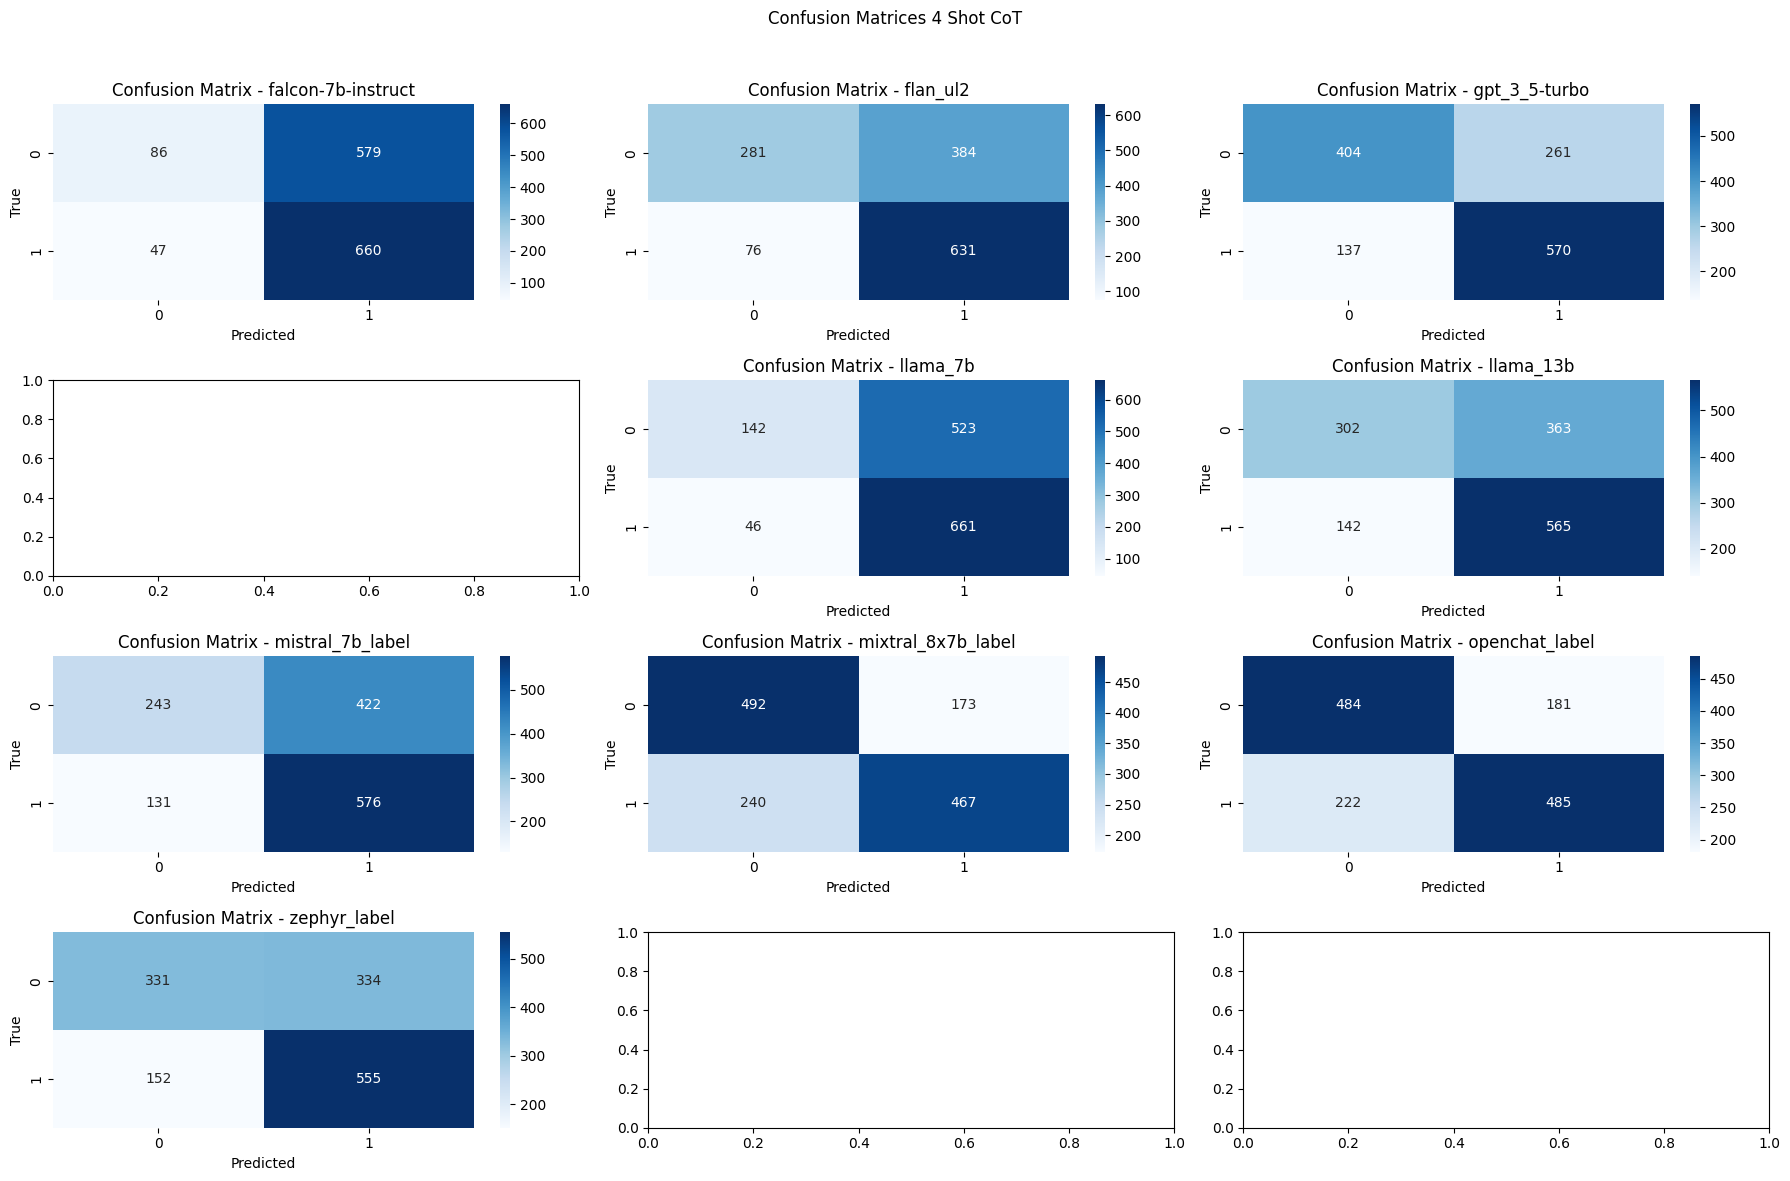

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', f'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', f'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', f'gpt_3_5-turbo')
#plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', f'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', f'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', f'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', f'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', f'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', f'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [74]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [75]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.24151512680258358
Krippendorff's Alpha (all runs without invalid data): 0.2198449407093913


In [76]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [77]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.19527704373497745
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.14203308159199357
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.1429356376943649
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.1139444814587034
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.07261849958772426
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.12098834012919779
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.14555061100885203
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.09336287161116719
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_13b_label'), Alpha: 0.12832466724984215
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'mistral_7b_label'), Alpha: 0.11947510375508819
Combination: ('falcon_7b_lab

(0.45413860036702647,
 ('gpt_3_5_label', 'mixtral_8x7b_label', 'openchat_label'))

In [78]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.22401548523503678
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.13036665462849895
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.1258590098807999
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.12685754659498338
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.11864723986782244
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.15487823636091957
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.16130851052714468
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.08994281190253606
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_13b_label'), Alpha: 0.09196325481676537
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'mistral_7b_label'), Alpha: 0.11998865444499007
Combination: ('falcon_7b_la

(0.48218818885927817,
 ('gpt_3_5_label', 'mixtral_8x7b_label', 'openchat_label'))

In [79]:
df_merge_all_runs.shape

(1372, 20)

In [80]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

UndefinedVariableError: name 'gpt_4_label' is not defined